## 知識情報学第9回演習サンプルプログラム ex9.ipynb
- Programmed by Nattapong Thammasan, 監修　福井健一
- Last updated: 2019/12/19
- Checked with Python 3.8, scikit-learn 0.23.2
- MIT License

## Wineデータに対するアンサンブル学習による識別
- 【課題2】アンサンブル数や木の最大深さを変更して，影響を考察しなさい．
 - 特徴量を工夫すると良い

In [1]:
%matplotlib inline
from functools import partial
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier,RandomForestClassifier, GradientBoostingClassifier
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# random state seed
rs = 42

### Wineデータの読み込み

In [2]:
wine = datasets.load_wine()
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [3]:
X=scale(wine.data)
y = wine.target

In [4]:
# PCAで2次元に圧縮
pca = PCA(n_components=2)
X_pca= pca.fit_transform(X)

### 識別境界面をプロットする関数

In [5]:
x1_min, x1_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
x2_min, x2_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))

markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y))])
    
def plot_decision_boundary(Z1, classifer_name):

    Z1 = Z1.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z1, alpha=0.5, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X_pca[y == cl, 0], y=X_pca[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl)

    plt.xlabel('pca1')
    plt.ylabel('pca2')
    plt.title(classifer_name)
    
    plt.show()

### 決定木

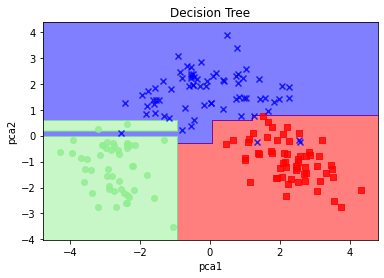

In [6]:
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=4,
                              random_state=rs)

tree.fit(X_pca, y)
Z = tree.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
plot_decision_boundary(Z, 'Decision Tree')

### 課題1(b) クロスバリデーションによる評価（学習データ，テストデータ）を追加

In [7]:
def cross_val(clf, cv = 5):
    res = cross_validate(clf, X_pca, y, cv=cv, return_train_score=True)
    train_score = res['train_score']
    test_score = res['test_score']    
    train_acc = sum(train_score) / len(train_score)
    test_acc = sum(test_score) / len(test_score)
    return train_acc, test_acc

上でのナイーブな決定木のみの訓練性能，テスト性能は以下の通りである．

In [8]:
train_acc, test_acc = cross_val(tree)
print(f'mean train accuracy : {train_acc:.03}')
print(f'mean test accuracy  : {test_acc:.03}')

mean train accuracy : 0.987
mean test accuracy  : 0.938


### 課題1(a),(b) Bagging

弱学習器の決定木のパラメータを変えると性能が変わるが，今回の実験では上の実験で作成した決定木と設定を共有することとする．  
また，弱学習器は100本作ることとする．

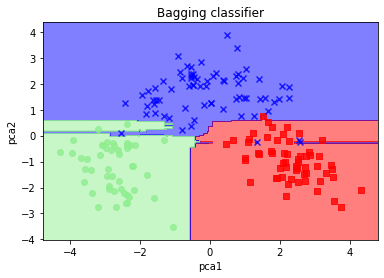

In [9]:
basis = DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=rs)
clf = BaggingClassifier(basis, n_estimators=100,random_state=rs)
clf.fit(X_pca, y)
Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
plot_decision_boundary(Z, 'Bagging classifier')

In [10]:
train_acc, test_acc = cross_val(clf)
print(f'mean train accuracy : {train_acc:.03}')
print(f'mean test accuracy  : {test_acc:.03}')

mean train accuracy : 0.994
mean test accuracy  : 0.949


### 課題1(a),(b) Random Forest

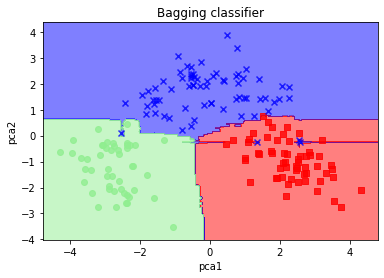

In [11]:
clf = RandomForestClassifier(n_estimators=100,random_state=rs)
clf.fit(X_pca, y)
Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
plot_decision_boundary(Z, 'Bagging classifier')

In [12]:
train_acc, test_acc = cross_val(clf)
print(f'mean train accuracy : {train_acc:.03}')
print(f'mean test accuracy  : {test_acc:.03}')

mean train accuracy : 1.0
mean test accuracy  : 0.955


### 課題1(a),(b) AdaBoost
- scikit-learnのAdaBoostClassifierは，デフォルトのbase_estimatorがDecisionTreeClassifier(max_depth=1)のため注意

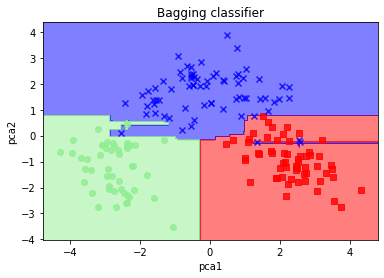

In [13]:
basis = DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=rs)
clf = AdaBoostClassifier(basis, n_estimators=100,random_state=rs)
clf.fit(X_pca, y)
Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
plot_decision_boundary(Z, 'Bagging classifier')

In [14]:
train_acc, test_acc = cross_val(clf)
print(f'mean train accuracy : {train_acc:.03}')
print(f'mean test accuracy  : {test_acc:.03}')

mean train accuracy : 1.0
mean test accuracy  : 0.932


### 課題1(a),(b) Gradient Boosting

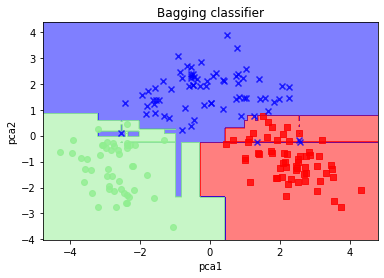

In [15]:
clf = GradientBoostingClassifier(n_estimators=100,random_state=rs)
clf.fit(X_pca, y)
Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
plot_decision_boundary(Z, 'Bagging classifier')

In [16]:
train_acc, test_acc = cross_val(clf)
print(f'mean train accuracy : {train_acc:.03}')
print(f'mean test accuracy  : {test_acc:.03}')

mean train accuracy : 1.0
mean test accuracy  : 0.921


### 課題1(c) RandomForestを使用して特徴量をランキング
- ヒント：ソート結果のインデックスはnp.argsort()を使用すると良い

In [17]:
import pandas as pd
feature_name = ["Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols",
                "Flavanoids", "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]

clf = RandomForestClassifier(n_estimators=100,random_state=rs)
clf.fit(X, y)
feature_importance = clf.feature_importances_
df = pd.DataFrame([feature_importance], columns=feature_name)

In [18]:
df = df.sort_values(0,axis = 1, ascending=False)

In [19]:
df

,Flavanoids,Color intensity,Alcohol,Proline,OD280/OD315 of diluted wines,Hue,Total phenols,Malic acid,Alcalinity of ash,Magnesium,Proanthocyanins,Ash,Nonflavanoid phenols
0,0.194481,0.172961,0.141614,0.137045,0.111831,0.076939,0.03508,0.03306,0.029885,0.025873,0.018387,0.015534,0.00731


<BarContainer object of 13 artists>

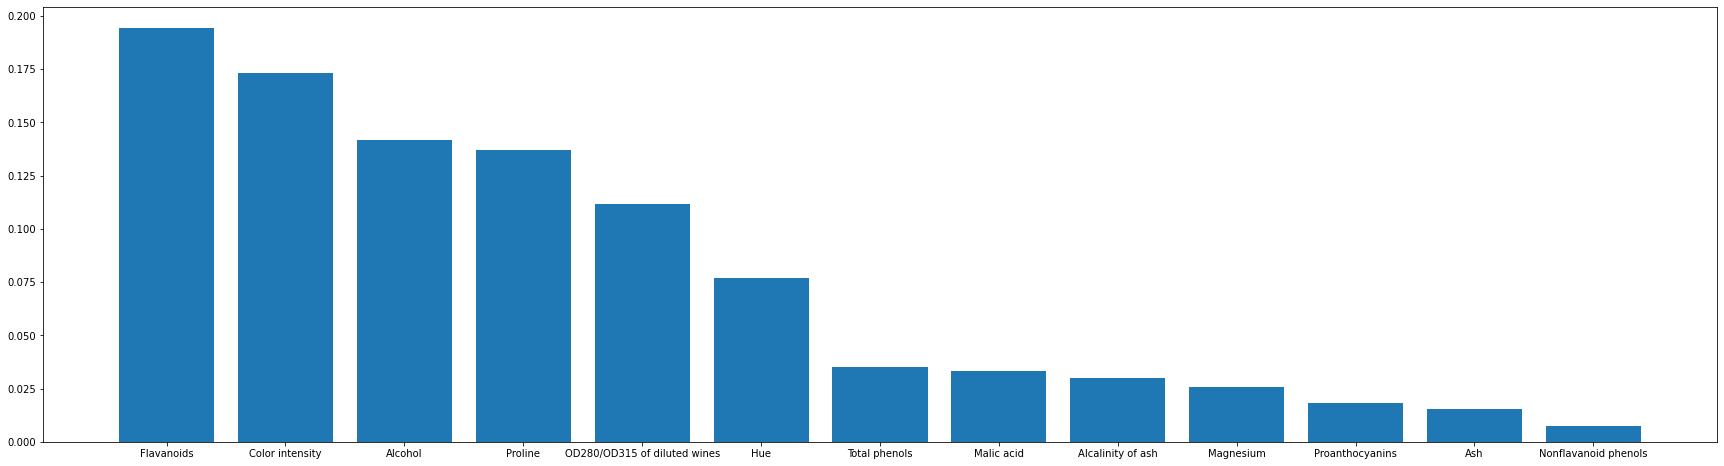

In [20]:
plt.figure(figsize = (30,8))
plt.bar(df.columns, df.iloc[0])

上のグラフはランダムフォレストのモデルにおける重要特徴量のランキングである．  
random forestによる分類モデルにおいて重要な特徴量はフラボノイド(ポリフェノール?)量，色彩強度，アルコール濃度，プロリンの値が特に重要であるということがわかる．  

### 課題9-2 アンサンブルの数やきの最大深さを変更して影響を考察

以下Baggingにおいてアンサンブルの数と最大深さを変化させていった際にどのようにテスト分類性能が変化するのかを検証する

In [21]:
from tqdm.notebook import tqdm
num_max_depth = [1,2,3,4,5,10,50]
num_ensamble = [1,2,3,4,5,10,50]

Z_train = np.zeros((len(num_max_depth), len(num_ensamble)))
Z_test = np.zeros((len(num_max_depth), len(num_ensamble)))


for i,d in enumerate(tqdm(num_max_depth)):
    for j,n in enumerate(tqdm(num_ensamble,leave = False)):
        basis = DecisionTreeClassifier(criterion='entropy',max_depth=d,random_state=rs)
        clf = BaggingClassifier(basis, n_estimators=n,random_state=rs)
        train_acc, test_acc = cross_val(clf)
        Z_train[i][j] = train_acc
        Z_test[i][j] = test_acc

In [22]:
num_ensamble

[1, 2, 3, 4, 5, 10, 50]

<ipython-input-23-364ef05b98cf>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([1] + num_ensamble)
<ipython-input-23-364ef05b98cf>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([1] + num_ensamble)


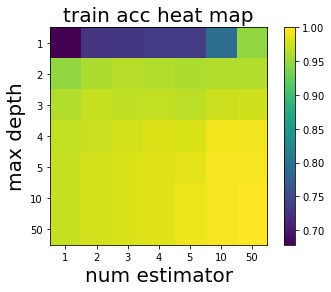

In [23]:
fig,ax = plt.subplots()
ax.set_title("train acc heat map", fontsize=20)
ax.set_xlabel([0,1])
ax.set_xticklabels([1] + num_ensamble)
ax.set_yticklabels([1] + num_ensamble)
ax.set_xlabel("num estimator", fontsize = 20)
ax.set_ylabel("max depth", fontsize = 20)
im = ax.imshow(Z_train)
fig.colorbar(im)

In [24]:
print("training score")
for i in range(len(Z_train)):
    for j in range(len(Z_train)):
        print(f"{Z_train[i][j]:<5.03}", end=' ')
    print()

training score
0.678 0.727 0.73  0.736 0.736 0.795 0.948 
0.948 0.961 0.965 0.963 0.961 0.963 0.963 
0.964 0.972 0.969 0.971 0.968 0.975 0.976 
0.971 0.975 0.979 0.983 0.982 0.993 0.994 
0.972 0.978 0.982 0.985 0.987 0.996 0.996 
0.972 0.978 0.982 0.985 0.992 0.996 1.0   
0.972 0.978 0.982 0.985 0.992 0.996 1.0   


<ipython-input-25-4fd2420536b5>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([1] + num_ensamble)
<ipython-input-25-4fd2420536b5>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([1] + num_ensamble)


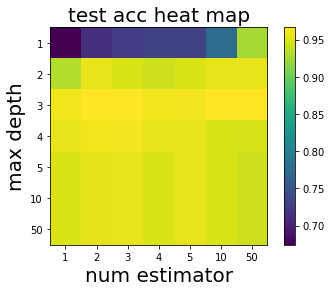

In [25]:
fig,ax = plt.subplots()
ax.set_title("test acc heat map",fontsize =20)
ax.set_xlabel([0,1])
ax.set_xticklabels([1] + num_ensamble)
ax.set_yticklabels([1] + num_ensamble)
ax.set_xlabel("num estimator", fontsize = 20)
ax.set_ylabel("max depth", fontsize = 20)
im = ax.imshow(Z_test)
fig.colorbar(im)

In [26]:
print("test score")
for i in range(len(Z_train)):
    for j in range(len(Z_train)):
        print(f"{Z_test[i][j]:<5.03}", end=' ')
    print()

test score
0.674 0.714 0.726 0.731 0.731 0.776 0.927 
0.933 0.955 0.95  0.944 0.95  0.955 0.955 
0.961 0.966 0.966 0.961 0.961 0.966 0.966 
0.955 0.961 0.961 0.955 0.955 0.949 0.949 
0.949 0.955 0.955 0.949 0.955 0.949 0.944 
0.949 0.955 0.955 0.949 0.955 0.949 0.944 
0.949 0.955 0.955 0.949 0.955 0.949 0.944 


計算結果より訓練性能は決定木の深さが深くなればなるほど，学習器の多さが多くなればなるほど性能が向上していることが読み取れる．  
一方でテスト性能について見てみると決定木の最大深さが3,学習木の個数が10から50くらいの時に性能が最も良くなっている．  
このことより，アンサンブル学習においても元となる弱学習器の表現力が高すぎると過学習してしまうことがわかる．  
上の実験の傾向では，弱学習器の最大深さが3の時は50個のアンサンブルをしても過学習が起こらなかったため，基底となる学習木の性能は弱く，アンサンブルする学習木の数はある程度大きい値でも過学習が起きないということが示唆される．  

### その他工夫点

上ではrandom forestでの重要特徴量をみた．  
本実験では同じく，特徴量の重要度を計算するアルゴリズムであるPermutation Feature Importanceを用いて上の結果と整合するのかを確認する

PFIはsklearnに実装されているのでそれを用いることにする(https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)

In [27]:
from sklearn.inspection import permutation_importance

In [28]:
clf = RandomForestClassifier(n_estimators=100,random_state=rs)
clf.fit(X, y)
pfi = permutation_importance(estimator = clf, X=X, y=y,random_state = rs, n_repeats=10)

In [30]:
df_pfi = pd.DataFrame(
    data = {"feature name" : feature_name, "importance" : pfi["importances_mean"]}
).sort_values("importance",ascending=False)

In [31]:
df_pfi

,feature name,importance
12,Proline,0.048876
9,Color intensity,0.037079
6,Flavanoids,0.029213
0,Alcohol,0.006742
1,Malic acid,0.000000
2,Ash,0.000000
3,Alcalinity of ash,0.000000
4,Magnesium,0.000000
5,Total phenols,0.000000
7,Nonflavanoid phenols,0.000000


実験結果より詳細な順番は違うものの，プロリン，色彩強度，フラボノイド量，アルコール濃度というrandom forestでも上位4つに入っていた特徴量が重要という結果が得られた．  